# Multifeature logistic decoders

The ECoG recordings feature multiple channels, and the signal on each channel can be decomposed into multiple frequency bands. Changes in activities in both the high and low frequency bands changed during finger flexions. Can we use this multichannel and multifrequency activity to decode finger flexions? So far we have built logistic decoders that use only a single feature, but we may be able to get better performance if multiple features were used. This week we will discuss how to use logistic decoders with multiple features.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from source.helpers import zscore

## Spatial pattern of spectral changes

Last week we started working with ECoG recordings from subjects while they moved their fingers. The grid had 64 electrodes placed directly on the cortical surface. When a subject moved a finger there was a localized pulse of activity over part of the cortex. This appeared as an ERP, but also as an increased incidence of high frequency activity bursts, and a decrease in low frequency power. These bursts are closely related to local processing in the cortex. Since different parts of cortex control different parts of the body (including individual fingers), each motor action would create a different pattern of high frequency bursts acros the ECoG array.

Let's load the data from last week and see if spectral activity differed in their spatial pattern across different finger movements.

In [2]:
flex_events = np.load('../Week7/data/flex.npy')
locs = np.load('../Week7/data/locs.npy')
fs = np.load('../Week7/data/fs.npy')
Y_all = np.load('../Week7/data/Y_all.npy')
freqs = np.load('../Week7/data/freqs.npy')
t = np.load('../Week7/data/t.npy')

In [3]:
# let's convert our spectrogram to magnitude, since the phase information is not relevant for decoding
Y_all = np.abs(Y_all)

# and z-score to normalize each frequency
Y_all = zscore(Y_all, dim=2)

We will get the mean spectrum during finger movements. To do this, we have to convert the `flex_events` times, which are sampled at 1000 kHz, to the sampling rate of the spectrogram. Our step size was 50 ms, so the sample rate of the spectrogram is 20 Hz (1/0.05 sec). To do this, we can use the numpy `interp` function. It performs *interpolation*, which allows you to pass a curve as a series of x and y points, and then get the y values for new x points that you specify. It does this by fitting a line between each adjacent pairs of data points, and then finding where your new x point lies on that line. 

Text(0.5, 1.0, 'Comparison of original and interpolated flex time series')

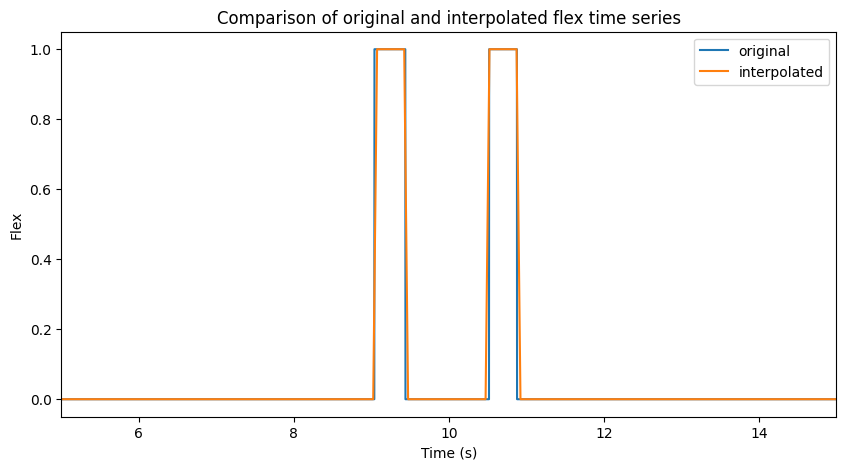

In [4]:
# create time vector for flex events
flex_t = np.arange(0, flex_events.shape[0])/fs

# convert flex time series to same time scale as spectrogram
flex_spec = np.zeros([t.shape[0], flex_events.shape[1]])

for i in range(flex_events.shape[1]):
    flex_spec[:,i] = np.interp(t, flex_t, flex_events[:,i])!=0

# plot original and interpolated flex time series
plt.figure(figsize=(10,5))
plt.plot(flex_t, flex_events[:,0], label='original')
plt.plot(t, flex_spec[:,0], label='interpolated')
plt.xlim([5, 15])
plt.xlabel('Time (s)')
plt.ylabel('Flex')
plt.legend()
plt.title('Comparison of original and interpolated flex time series')


Looks good enough for our purposes. Just a few differences at the start and stops of reaching epochs.

Looking back on the movement triggered spectrograms from last week, it was apparent that the strongest changes was at the start of a finger movement.

![movement spectrogram](./images/MeanSpecMovementStart.png)

You can see that the spectral changes start approximately a two hundred milliseconds prior to the finger movement, and end a two hundred milliseconds after. This is the event we wish to detect. So, we will sample the spectrogram for 200 ms before and after the movement onset.

First we will get the time periods surrounding finger movements.

Text(0.5, 1.0, 'Onsets and onset windows')

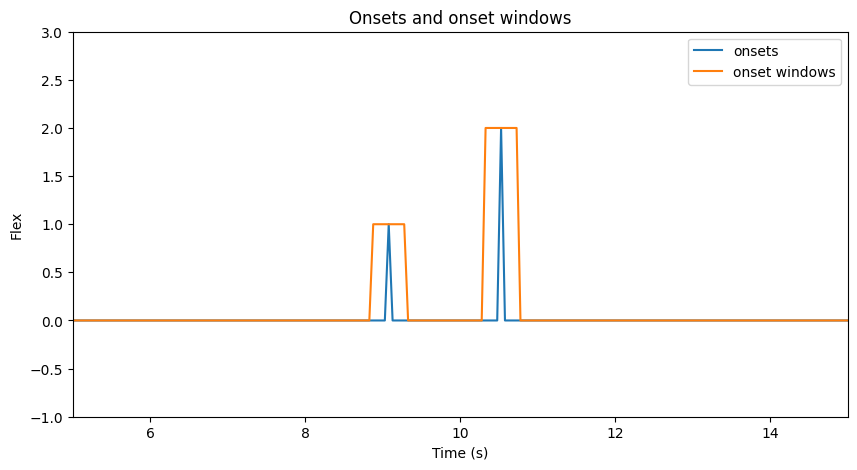

In [16]:
# kernel for convolution to window around onsets
spec_fs = int(1/(t[1]-t[0]))
pre_t = 0.2
post_t = 0.2
onset_kern = np.ones([int((pre_t+post_t)*spec_fs)+1]) # +1 to make it odd, so kernel is symmetric around 0

# determine onsets of flex events
flex_spec_onsets = (np.diff(flex_spec,axis=0)>0).astype(int)

# pad onsets to match size of spectrogram
flex_spec_onsets = np.pad(flex_spec_onsets, ((1,0),(0,0)), 'constant', constant_values=0)

# count each onset event and convolve onsets with pre/post kernel
flex_spec_onwin = np.zeros(flex_spec_onsets.shape)
for i in range(flex_spec_onsets.shape[1]):
    flex_spec_onsets[flex_spec_onsets[:,i]>0,i] = np.arange(1, np.sum(flex_spec_onsets[:,i])+1)
    flex_spec_onwin[:,i] = np.convolve(flex_spec_onsets[:,i], onset_kern, mode='same')

# plot onset and onset windows
plt.figure(figsize=(10,5))
plt.plot(t, flex_spec_onsets[:,0], label='onsets')
plt.plot(t, flex_spec_onwin[:,0], label='onset windows')
plt.xlim([5, 15])
plt.ylim([-1, 3])
plt.xlabel('Time (s)')
plt.ylabel('Flex')
plt.legend()
plt.title('Onsets and onset windows')


Now we calculate the mean spectrum during each movement period. To do this, for each movement type we get the mean spectral power across movement onset times for each channel.

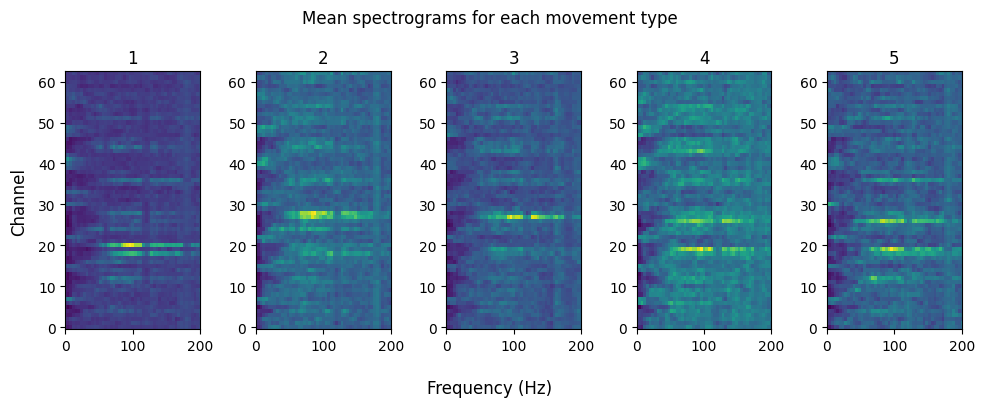

In [28]:
# get the mean spectrum for each movement type, onset epoch, and channel
flex_spec_epochs = []
for i in range(flex_spec_onwin.shape[1]):
    spec_temp = np.zeros([Y_all.shape[0], Y_all.shape[1], int(np.max(flex_spec_onwin[:,i]))])
    for j in range(Y_all.shape[0]):
        for k in range(Y_all.shape[1]):
            for l in range(int(np.max(flex_spec_onwin[:,i]))):
                spec_temp[j,k,l] = np.mean(Y_all[j,k,flex_spec_onwin[:,i]==l+1])
    flex_spec_epochs.append(spec_temp)

# get the mean spectrum for each movement type and channel
flex_spec_means = np.zeros([5, Y_all.shape[0], Y_all.shape[1]])
for i in range(5):
    flex_spec_means[i,:,:] = np.mean(flex_spec_epochs[i], axis=2)


# plot mean spectrograms for each movement type
fig, ax = plt.subplots(1,5,figsize=(10,4))
for i in range(5):
    ax[i].pcolormesh(freqs, np.arange(63), flex_spec_means[i,:,:])
    ax[i].set_title(str(i+1))
    ax[i].set_xlim([0, 200])
fig.suptitle('Mean spectrograms for each movement type')
fig.supxlabel('Frequency (Hz)')
fig.supylabel('Channel')
fig.tight_layout()
    

In the above plot, each subplot is a different movement type. The increases in high frequency power vary across movement types. For instance, the peak channels for movement type 1 are on channels 18 and 20, while for movement type 2 they are on 27 and 28th. The decrease in low frequency power are less channel specific, but they too may prove informative. Thus, we want to use these channel specific spectral differences to try and decode whether a specific movement occurred. 

We can plot these onto the ECoG grid, to get a better sense of the spatial distribution of these two bands of activity.

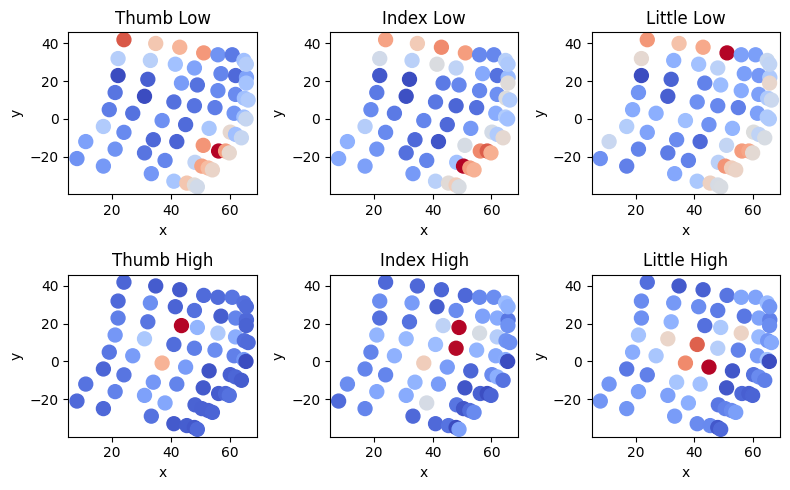

In [29]:
low_freqs = freqs<20
high_freqs = freqs>50

# mean power in low and high frequency bands for each movement type and channel
flex_spec_low = np.mean(flex_spec_means[:,:,low_freqs], axis=2)
flex_spec_high = np.mean(flex_spec_means[:,:,high_freqs], axis=2)


# plot locs colored by erp
def spec_grid(locs, spec, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(locs[:, 0], locs[:, 1], c=spec[:], cmap='coolwarm', s=100)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return ax

fig, ax = plt.subplots(2, 3, figsize=(8, 5))
spec_grid(locs, flex_spec_low[0,:].squeeze(), ax=ax[0,0])
ax[0,0].set_title('Thumb Low')
spec_grid(locs, flex_spec_high[0,:].squeeze(), ax=ax[1,0])
ax[1,0].set_title('Thumb High')
spec_grid(locs, flex_spec_low[1,:].squeeze(), ax=ax[0,1])
ax[0,1].set_title('Index Low')
spec_grid(locs, flex_spec_high[1,:].squeeze(), ax=ax[1,1])
ax[1,1].set_title('Index High')
spec_grid(locs, flex_spec_low[4,:].squeeze(), ax=ax[0,2])
ax[0,2].set_title('Little Low')
spec_grid(locs, flex_spec_high[4,:].squeeze(), ax=ax[1,2])
ax[1,2].set_title('Little High')
fig.tight_layout()

Laying out the spectral power across the ECoG grid makes the movement-related patterns more apparent. We divided spectral power into low (<20 Hz) and high (>50 Hz) bands, and plotted them on each ECoG grid location. For the low power, there was not much differentiation between movement types. The top left and bottom right portions of the grid showed consistant elevations, and the middle was low. On the other hand, high frequency power was elevated on distinct sets of electrodes near the middle of the array. This difference is crucial for classifying each type of movement. Some movements, such as thumb raising, strongly activate only one site, while others, such as little finger movement, activate 3.

In the ERP decoding we did previously, we focused on just a single electrode and measure, the match to the ERP. While we may be tempted to take the same approach here, such as measuring the high frequency power on the electrode where it is strongest for each movement, the other sites might offer additional information for decoding. For instance, two sites show substantial increases in high frequency power for index finger movement. If the activation on those sites is perfectly correlated, then we could use just one of them without losing information. But imagine that one of the sites is active on half the trials, and the other is activated on the other half. In that case, only focusing on one of them means we could miss 50% of movements. Instead, we would want to pool them together.

We can see if this is the case by plotting the relationship between the activation on those sites across trials.

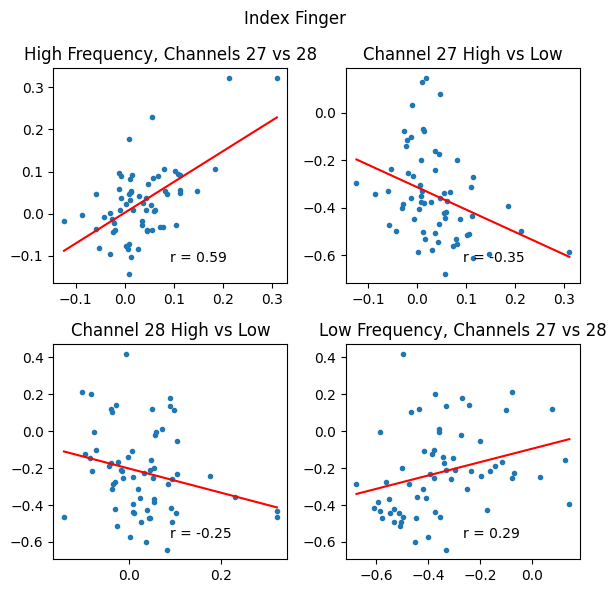

In [38]:
# plot mean power in low and high frequency bands for index finger movements on each channel and epoch
index_spec_low = np.mean(flex_spec_epochs[1][:,low_freqs,:], axis=1)
index_spec_high = np.mean(flex_spec_epochs[1][:,high_freqs,:], axis=1)

# identify top two channels for high frequency power
top_chans = np.argsort(np.mean(index_spec_high, axis=1))[-2:]


# function for scatter plot with best fit line and correlation coefficient
def scatter_fit(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, '.')
    # add linear fit and correlation coefficient to plot
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'r')
    ax.text(0.5, 0.1, 'r = ' + str(np.round(np.corrcoef(x, y)[0,1], 2)), transform=ax.transAxes)
    return ax

# plot mean power in low and high frequency bands for index finger movements on each channel and epoch
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
scatter_fit(index_spec_high[:,top_chans[0]], index_spec_high[:,top_chans[1]], ax=ax[0,0])
ax[0,0].set_title('High Frequency, Channels ' + str(top_chans[0]) + ' vs ' + str(top_chans[1]))

scatter_fit(index_spec_low[:,top_chans[0]], index_spec_low[:,top_chans[1]], ax=ax[1,1])
ax[1,1].set_title('Low Frequency, Channels ' + str(top_chans[0]) + ' vs ' + str(top_chans[1]))

scatter_fit(index_spec_high[:,top_chans[0]], index_spec_low[:,top_chans[0]], ax=ax[0,1])
ax[0,1].set_title('Channel ' + str(top_chans[0]) + ' High vs Low')

scatter_fit(index_spec_high[:,top_chans[1]], index_spec_low[:,top_chans[1]], ax=ax[1,0])
ax[1,0].set_title('Channel ' + str(top_chans[1]) + ' High vs Low')
fig.suptitle('Index Finger')
fig.tight_layout()


Focusing on the two sites with the strongest high frequency activity during index finger movements, we can see that they are correlated, but not perfectly. In the top left plot, where we compare high frequency activity between both top sites, we can see that they have a correlation coefficient around 0.6. This means that on any given index finger movement the sites are not providing redundant information, so it makes sense to combine them. A similar trend is seen for low frequency power (lower right plot). In addition, low and high frequency power was partially anticorrelated at each site. Altogether, the lack of perfect correlations (r = 1) means that we should try to combine these measures when estimating whether an index finger was moved. This requires that our logistic decoder accepts multiple features.

## Multifeature logistic decoder
The logistic decoders we ran previously accepted just a single input. Now, however, we want to use many inputs. These will be the spectrum for each channel. With 63 channels and 50 frequencies that means we would supply 3150 features ($63 \times 50$). This requires a subtle change to the equation we use for the logistic model. Recall that the original equation with 1 feature was:

$$ \sigma(x) = \frac{1}{1+e^{-(b+wx)}} $$

Here $x$ represents the one feature, along with $w$ being the weight for that feature. If we want to include multiple features, we can write the equation as:

$$ \sigma(x) = \frac{1}{1+e^{-(b+w_1x_1+w_2x_2+...w_nx_2)}} $$

where there are $n$ different features. Alternatively, we can write it using the summation symbol as:

$$ \sigma(x) = \frac{1}{1+e^{-(b+\sum_{i=1}^{n}w_ix_i)}} $$





## Regularization
Overfitting

L1 vs L2

effect on loss landscape

## Hyperparameter optimization 

Train, validation, and test sets